# LoadDataset

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

在```1. LoadData```中我们已经知道如何使用Pytorch加载数据集,现在我们搭建一个合适的具有样本划分为训练/测试的```DataLoader```.

### 1. Split Data Set

首先,我们需要将数据集```CatsVsDogs```拆分为train/test data.

SplitData类接受4个参数:

1.file_dir:文件路径.

2.Load_samples: 加载的样本量大小,如果为```None```则全部加载.

3.Shuffle: 是否打乱数据,建议打乱.

4.test_rate: 测试样本率.

返回4个值:

1.train_files: 含有训练样本的路径.

2.test_files: 含有测试样本的路径.

3.train_samples: 训练样本总数.

4.test_samples: 测试样本总数.

In [2]:
class SplitData:

    def __init__(self, file_dir, Load_samples=None, Shuffle=True, test_rate=0.3):
        """
        Argus:
        -----
            file_dir (string): data set file path like "../train/"
            Load_samples (Int): Load_samples (Int): Load data number. if given None, load all samples.
            Shuffle (bool): is shuffle data set. Suggest True. default true.
            test_rate (float): split test data rate. default 0.3.
        """
        self.file_dir = file_dir
        self.test_rate = test_rate
        self.Load_samples = Load_samples
        self.Shuffle = Shuffle

    def __call__(self):

        # loading all path in current file dir.
        files_list = os.listdir(self.file_dir)

        if self.Shuffle:
            np.random.shuffle(files_list)

        if self.Load_samples:
            files_list = files_list[:self.Load_samples]

        # split data
        len_ = len(files_list)
        test_index = int(np.floor(len_ * self.test_rate))
        test_files = files_list[:test_index]
        train_files = files_list[test_index:]

        # join path
        test_files = [os.path.join(self.file_dir, file) for file in test_files]
        train_files = [os.path.join(self.file_dir, file) for file in train_files]

        train_samples, test_samples = len_ - test_index, test_index

        return train_files, test_files, train_samples, test_samples

这里我们尝试加载10个样本,测试样本率0.3.

In [3]:
file_dir = '/Users/huwang/Joker/Data_Set/catVSdot/train'
split_data = SplitData(file_dir, Load_samples=10, test_rate=0.3)
train_files, test_files, train_samples, test_samples = split_data()

print('Train Samples is {}, Test Samples is {}'.format(train_samples,test_samples))
print('First train file path: {}'.format(train_files[0]))

Train Samples is 7, Test Samples is 3
First train file path: /Users/huwang/Joker/Data_Set/catVSdot/train/dog.2967.jpg


这样我们就能够划分出训练样本和测试样本,接下去我们需要将其传递到```Load```中进行处理.

### 2.1 Load

现在我们能够拆分训练/测试集,接着我们就使用Load去加载数据.

```Loader```类接受两个参数:

1.data_files: 由SplitData返回的train/test的列表,其中含有划分完毕的样本路径.

2.transform: 是否使用相应的其他transform功能.

需要注意的是,由于我们接下去要将```img,label```转换为```Tensor```类型,如果我们使用```torch.IntTensor(label)```进行转换那么其中的```label```将是一个列表或者是一个意味的数组,如果只是一个整型则无法转换成功,比如以下代码:

In [4]:
label = 1
tensor = torch.IntTensor(label)
print('The tensor is:{}'.format(tensor))

label = np.array([1])
tensor = torch.IntTensor(label)
print('The tensor is:{}'.format(tensor))

The tensor is:tensor([0], dtype=torch.int32)
The tensor is:tensor([1], dtype=torch.int32)


可以看到如果```torch.IntTensor(number)```中的number只是一个整型那么将会转换失败,实际上```FloatTensor```亦是如此.

另外这里就不在使用Normal对图像进行预处理了,转而直接使用```np.divide(img, 255)```.

In [5]:
class Load(Dataset):

    def __init__(self, data_files, transform=None):
        """
        Argus:
        ------
            data_files (string): load data files, it's a list. it include "file path".
            transform (class):  using any class(ToTensor()) of sample.
            
        Return:
        ------
            sample (tuple): include img and label.
        """
        self.data_files = data_files
        self.transform = transform

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, item):

        file_path = self.data_files[item]

        classes = file_path.split('/')[-1].split('.', 1)[0]
        if classes == 'cat':
            label = 0
        else:
            label = 1

        img = Image.open(file_path)
        img = img.resize((224, 224))
        img = np.array(img)

        img = np.divide(img, 255)

        img = np.pad(img, pad_width=((1, 2), (1, 2), (0, 0)), mode='constant')

        sample = (img, np.array([label]))

        if self.transform:
            sample = self.transform(sample)

        return sample

现在我们来尝试一下```Load```类,并且显示第一张图片.

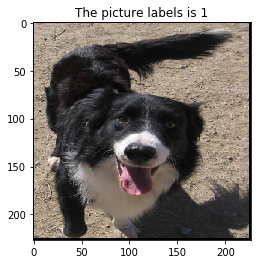

In [6]:
loader = Load(train_files)
img,label = loader[0]
plt.imshow(img)
plt.title('The picture labels is {}'.format(label[0]))
plt.show()

接下去我们即需要将加载出来的训练/测试样本转换为Tensor.

### 2.2 ToTensor

In [7]:
class ToTensor:

    def __call__(self, sample):
        img, label = sample
        n_w, n_h, n_c = img.shape

        img = img.reshape((n_c, n_h, n_w))
        img = torch.FloatTensor(img)
        label = torch.IntTensor(label)

        sample = (img, label)

        return sample

此处代码与```1. LoadData```中一致就不在过多阐述.

最后我们测试一下,看看是否能够按照我们的要求加载样本,加载样本总数为10,测试样本率为0.3.

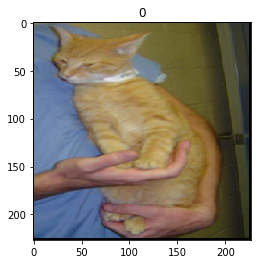

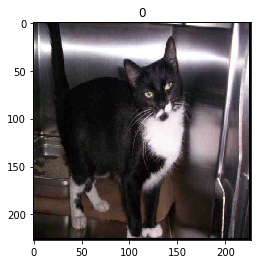

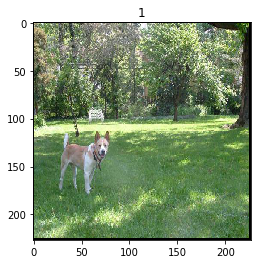

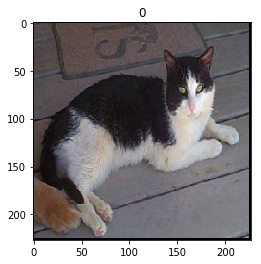

In [8]:
file_dir = '/Users/huwang/Joker/Data_Set/catVSdot/train'
split_data = SplitData(file_dir, Load_samples=10, test_rate=0.3)
train_files, test_files, train_samples, test_samples = split_data()

load = Load(train_files,transform=ToTensor())
train_loader = DataLoader(load,batch_size=2,shuffle=True,num_workers=2)

for img,label in train_loader:
    img = img[0].numpy()
    img = img.reshape((227,227,3))
    plt.imshow(img)
    plt.title(label[0].item())
    plt.show()

可以看到我们的样本能够按照我们的需求加载,接下去我们就尝试搭建Pytorch of AlexNet.